In [1]:
from IPython.core.interactiveshell import InteractiveShell
from sklearn import model_selection, ensemble, preprocessing, metrics
from talib import abstract
from __future__ import print_function
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from fractions import Fraction as F
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import pandas as pd
import sys
import random
import json
import talib as ta
import keras

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submit = pd.read_csv('gender_submission.csv')

In [3]:
selected_features = ['Ticket','Pclass', 'Name','Sex','Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
X_train = train[selected_features]
X_test = test[selected_features]
y_train = train['Survived']

# 補缺值

In [4]:
X_train['Embarked'].fillna('S', inplace=True)
X_train['Family_Size'] = X_train['Parch'] + X_train['SibSp']
X_train['Title'] = X_train['Name'].str.split(", ", expand=True)[1]
X_train['Title'] = X_train['Title'].str.split(".", expand=True)[0]

X_test['Fare'].fillna(X_test['Fare'].mean(), inplace=True)
X_test['Family_Size'] = X_test['Parch'] + X_test['SibSp']
X_test['Title'] = X_test['Name'].str.split(", ", expand=True)[1]
X_test['Title'] = X_test['Title'].str.split(".", expand=True)[0]

/usr/local/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Ticket Number 沒用到

In [6]:
X_train['Ticket'] = X_train['Ticket'].apply(lambda x : x.replace(".","").replace("/","").strip().split(' ')[0] if not x.isdigit() else 'X')
X_train['Ticket'].unique()
X_test['Ticket'] = X_test['Ticket'].apply(lambda x : x.replace(".","").replace("/","").strip().split(' ')[0] if not x.isdigit() else 'X')
X_test['Ticket'].unique()

AttributeError: 'int' object has no attribute 'isdigit'

# Cabin & CabinNum 有用到 

In [5]:
X_train['Cabin'].astype(str)
X_test['Cabin'].astype(str)

for i in range(len(X_train['Title'])):
    if sys.getsizeof(X_train['Cabin'][i]) == 54:
        X_train['Cabin'][i] = X_train['Cabin'][i][2:5]
    
    if sys.getsizeof(X_train['Cabin'][i]) == 58:
        X_train['Cabin'][i] = X_train['Cabin'][i][0:3]
    else:
        if sys.getsizeof(X_train['Cabin'][i]) >= 56:
            X_train['Cabin'][i] = X_train['Cabin'][i][0:3]
            
for i in range(len(X_test['Title'])):
    if sys.getsizeof(X_test['Cabin'][i]) == 54:
        X_test['Cabin'][i] = X_test['Cabin'][i][2:5]
    if sys.getsizeof(X_test['Cabin'][i]) == 58:
        X_test['Cabin'][i] = X_test['Cabin'][i][0:3]
    else:
        if sys.getsizeof(X_test['Cabin'][i]) >= 56:
            X_test['Cabin'][i] = X_test['Cabin'][i][0:3]
            
X_train["CabinNum"] = X_train['Cabin'].apply(lambda x : str(x)[1:] if not pd.isnull(x) else random.randint(1,50))
X_train["Cabin"] = X_train['Cabin'].apply(lambda x : str(x)[0] if not pd.isnull(x) else 'C')
X_test["CabinNum"] = X_test['Cabin'].apply(lambda x : str(x)[1:] if not pd.isnull(x) else '50')
X_test["Cabin"] = X_test['Cabin'].apply(lambda x : str(x)[0] if not pd.isnull(x) else 'C')

for i in range(len(X_test['CabinNum'])):
    if sys.getsizeof(X_test['CabinNum'][i]) == 49:
        X_test['CabinNum'][i] = '10'
    #if X_test['Cabin'][i] == 'T':
     #   X_test['Cabin'][i] = 'F'
for j in range(len(X_train['CabinNum'])):
    if sys.getsizeof(X_train['CabinNum'][j]) == 49:
        X_train['CabinNum'][j] = '10'
    #if X_train['Cabin'][j] == 'T':
     #   X_train['Cabin'][j] = 'F'
        
X_train['CabinNum']=X_train['CabinNum'].astype(str).astype(int)
X_test['CabinNum']=X_test['CabinNum'].astype(str).astype(int)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying t

# One Hot Encoding

In [6]:
X_train['Sex'] = X_train['Sex'].astype('category').cat.codes
X_test['Sex'] = X_test['Sex'].astype('category').cat.codes
X_train['Cabin'] = X_train['Cabin'].astype('category').cat.codes
X_test['Cabin'] = X_test['Cabin'].astype('category').cat.codes
X_train['Embarked'] = X_train['Embarked'].astype('category').cat.codes
X_test['Embarked'] = X_test['Embarked'].astype('category').cat.codes
X_train['Ticket'] = X_train['Ticket'].astype('category').cat.codes
X_test['Ticket'] = X_test['Ticket'].astype('category').cat.codes

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(X_train[['Sex','Cabin','Embarked','Ticket']])
enc.fit(X_test[['Sex','Cabin','Embarked','Ticket']])

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

# Age using ML: 沒用到
Pclass	Sex	Age	Fare	SibSp	Parch	Family_Size	Cabin	CabinNum	Embarked

In [7]:
dataAgeNull = X_train[X_train["Age"].isnull()]
dataAgeNotNull = X_train[X_train["Age"].notnull()]
remove_outlier = dataAgeNotNull[(np.abs(dataAgeNotNull["Fare"]-dataAgeNotNull["Fare"].mean())>(4*dataAgeNotNull["Fare"].std()))|
                      (np.abs(dataAgeNotNull["Family_Size"]-dataAgeNotNull["Family_Size"].mean())>(4*dataAgeNotNull["Family_Size"].std()))                     
                     ]
rfModel_age = RandomForestRegressor(n_estimators=2000,random_state=42)
ageColumns = ['Embarked', 'Fare', 'Pclass', 'Sex', 'Family_Size','Cabin','Ticket']
rfModel_age.fit(remove_outlier[ageColumns], remove_outlier["Age"])

ageNullValues = rfModel_age.predict(X= dataAgeNull[ageColumns])
dataAgeNull.loc[:,"Age"] = ageNullValues
X_train = dataAgeNull.append(dataAgeNotNull)
X_train.reset_index(inplace=True, drop=True)

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Age using average

In [7]:
X_train['Age'] = X_train['Age'].apply(lambda x : x if not pd.isnull(x) else 0)
for i in range(len(X_train['Title'])):
    
    if X_train['Age'][i] == 0:
        if X_train['Title'][i] == 'Capt':
            X_train['Age'][i] = 70.0
        if X_train['Title'][i] == 'Col':
            X_train['Age'][i] = 54.0
        if X_train['Title'][i] == 'Don':
            X_train['Age'][i] = 40.0
        if X_train['Title'][i] == 'Dona':
            X_train['Age'][i] = 39.0
        if X_train['Title'][i] == 'Dr':
            X_train['Age'][i] = 43.5
        if X_train['Title'][i] == 'Jonkheer':
            X_train['Age'][i] = 38.0
        if X_train['Title'][i] == 'Lady':
            X_train['Age'][i] = 48.0
        if X_train['Title'][i] == 'Major':
            X_train['Age'][i] = 48.5
        if X_train['Title'][i] == 'Master':
            X_train['Age'][i] = 5.48
        if X_train['Title'][i] == 'Miss':
            X_train['Age'][i] = 21.7
        if X_train['Title'][i] == 'Mlle':
            X_train['Age'][i] = 24.0
        if X_train['Title'][i] == 'Mme':
            X_train['Age'][i] = 24.0
        if X_train['Title'][i] == 'Mr':
            X_train['Age'][i] = 32.2
        if X_train['Title'][i] == 'Mrs':
            X_train['Age'][i] = 36.9
        if X_train['Title'][i] == 'Ms':
            X_train['Age'][i] = 28.0
        if X_train['Title'][i] == 'Rev':
            X_train['Age'][i] = 41.2
        if X_train['Title'][i] == 'Sir':
            X_train['Age'][i]= 49.0
        if X_train['Title'][i] == 'the Countess':
            X_train['Age'][i] = 33.0

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [8]:
X_test['Age'] = X_test['Age'].apply(lambda x : x if not pd.isnull(x) else 0)
for i in range(len(X_test['Title'])):
    
    if X_test['Age'][i] == 0:
        if X_test['Title'][i] == 'Capt':
            X_test['Age'][i] = 70.0
        if X_test['Title'][i] == 'Col':
            X_test['Age'][i] = 54.0
        if X_test['Title'][i] == 'Don':
            X_test['Age'][i] = 40.0
        if X_test['Title'][i] == 'Dona':
            X_test['Age'][i] = 39.0
        if X_test['Title'][i] == 'Dr':
            X_test['Age'][i] = 43.5
        if X_test['Title'][i] == 'Jonkheer':
            X_test['Age'][i] = 38.0
        if X_test['Title'][i] == 'Lady':
            X_test['Age'][i] = 48.0
        if X_test['Title'][i] == 'Major':
            X_test['Age'][i] = 48.5
        if X_test['Title'][i] == 'Master':
            X_test['Age'][i] = 5.48
        if X_test['Title'][i] == 'Miss':
            X_test['Age'][i] = 21.7
        if X_test['Title'][i] == 'Mlle':
            X_test['Age'][i] = 24.0
        if X_test['Title'][i] == 'Mme':
            X_test['Age'][i] = 24.0
        if X_test['Title'][i] == 'Mr':
            X_test['Age'][i] = 32.2
        if X_test['Title'][i] == 'Mrs':
            X_test['Age'][i] = 36.9
        if X_test['Title'][i] == 'Ms':
            X_test['Age'][i] = 28.0
        if X_test['Title'][i] == 'Rev':
            X_test['Age'][i] = 41.2
        if X_test['Title'][i] == 'Sir':
            X_test['Age'][i]= 49.0
        if X_test['Title'][i] == 'the Countess':
            X_test['Age'][i] = 33.0

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [9]:
X_train = X_train[['Ticket','Pclass','Sex', 'Age','SibSp','Cabin','Embarked','Family_Size','Fare', 'CabinNum', 'Parch']]
X_test = X_test[['Ticket','Pclass','Sex', 'Age','SibSp','Cabin','Embarked','Family_Size','Fare', 'CabinNum', 'Parch']]

In [89]:
X_train = X_train[['Ticket','Pclass','Sex','Embarked','Family_Size','Fare']]
X_test = X_test[['Ticket','Pclass','Sex','Embarked','Family_Size','Fare']]

# 沒用到：'SibSp', 'Parch','Ticket','Ticket','Age',,'Cabin','CabinNum', 

# Random Forest

In [22]:
rfc = RandomForestClassifier()

In [23]:
cross_val_score(rfc, X_train, y_train, cv=10).mean()

0.8171373850868233

In [24]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
survived_predict = rfc.predict(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [26]:
submission2=pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':survived_predict})
submission2.to_csv('submission.csv', index=False)

NameError: name 'survived_predict' is not defined

# Xgboost 0.83843

In [10]:
model = XGBClassifier(max_depth=11, n_estimators=300) #tuned 

In [11]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=11, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [12]:
cross_val_score(model, X_train, y_train, cv=10).mean()

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

0.8159380320054478

In [13]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [31]:
submission2=pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':y_pred})
submission2.to_csv('submission.csv', index=False)

# Show_Train_History

In [10]:
def show_train_history(train_history, train, validation):

    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()

# MLP

In [11]:
model = keras.models.Sequential()
model.add(Dense(units =50, input_dim=11,activation=('relu')))
model.add(Dropout(0.5))
model.add(Dense(units =40, kernel_initializer='uniform',activation=('relu')))
model.add(Dense(units = 1, kernel_initializer='uniform',activation=('relu')))
model.compile(loss='mse', optimizer='adam', metrics=['acc'])

In [20]:
X_train_1 = shuffle(X_train)
y_train_1 = shuffle(y_train)

In [21]:
train_history = model.fit(X_train_1, y_train_1, validation_split = 0.1, epochs=500,verbose =2)

Train on 801 samples, validate on 90 samples
Epoch 1/500
 - 0s - loss: 0.2756 - acc: 0.5431 - val_loss: 0.2559 - val_acc: 0.5333
Epoch 2/500
 - 0s - loss: 0.2454 - acc: 0.5818 - val_loss: 0.2522 - val_acc: 0.5556
Epoch 3/500
 - 0s - loss: 0.2387 - acc: 0.6242 - val_loss: 0.2511 - val_acc: 0.5444
Epoch 4/500
 - 0s - loss: 0.2371 - acc: 0.6205 - val_loss: 0.2506 - val_acc: 0.5556
Epoch 5/500
 - 0s - loss: 0.2337 - acc: 0.6305 - val_loss: 0.2476 - val_acc: 0.5667
Epoch 6/500
 - 0s - loss: 0.2375 - acc: 0.6142 - val_loss: 0.2503 - val_acc: 0.5667
Epoch 7/500
 - 0s - loss: 0.2367 - acc: 0.6217 - val_loss: 0.2533 - val_acc: 0.5556
Epoch 8/500
 - 0s - loss: 0.2336 - acc: 0.6267 - val_loss: 0.2511 - val_acc: 0.5667
Epoch 9/500
 - 0s - loss: 0.2349 - acc: 0.6255 - val_loss: 0.2504 - val_acc: 0.5556
Epoch 10/500
 - 0s - loss: 0.2341 - acc: 0.6230 - val_loss: 0.2515 - val_acc: 0.5556
Epoch 11/500
 - 0s - loss: 0.2317 - acc: 0.6217 - val_loss: 0.2504 - val_acc: 0.5667
Epoch 12/500
 - 0s - loss: 0.

Epoch 97/500
 - 0s - loss: 0.2309 - acc: 0.6342 - val_loss: 0.2475 - val_acc: 0.5667
Epoch 98/500
 - 0s - loss: 0.2289 - acc: 0.6355 - val_loss: 0.2487 - val_acc: 0.5667
Epoch 99/500
 - 0s - loss: 0.2329 - acc: 0.6217 - val_loss: 0.2475 - val_acc: 0.5778
Epoch 100/500
 - 0s - loss: 0.2284 - acc: 0.6305 - val_loss: 0.2472 - val_acc: 0.5667
Epoch 101/500
 - 0s - loss: 0.2325 - acc: 0.6242 - val_loss: 0.2487 - val_acc: 0.5556
Epoch 102/500
 - 0s - loss: 0.2323 - acc: 0.6280 - val_loss: 0.2509 - val_acc: 0.5556
Epoch 103/500
 - 0s - loss: 0.2297 - acc: 0.6242 - val_loss: 0.2496 - val_acc: 0.5667
Epoch 104/500
 - 0s - loss: 0.2290 - acc: 0.6330 - val_loss: 0.2487 - val_acc: 0.5667
Epoch 105/500
 - 0s - loss: 0.2340 - acc: 0.6242 - val_loss: 0.2470 - val_acc: 0.5556
Epoch 106/500
 - 0s - loss: 0.2299 - acc: 0.6305 - val_loss: 0.2500 - val_acc: 0.5556
Epoch 107/500
 - 0s - loss: 0.2298 - acc: 0.6367 - val_loss: 0.2509 - val_acc: 0.5444
Epoch 108/500
 - 0s - loss: 0.2289 - acc: 0.6292 - val_lo

Epoch 193/500
 - 0s - loss: 0.2265 - acc: 0.6305 - val_loss: 0.2480 - val_acc: 0.5444
Epoch 194/500
 - 0s - loss: 0.2271 - acc: 0.6255 - val_loss: 0.2515 - val_acc: 0.5444
Epoch 195/500
 - 0s - loss: 0.2312 - acc: 0.6242 - val_loss: 0.2489 - val_acc: 0.5556
Epoch 196/500
 - 0s - loss: 0.2287 - acc: 0.6317 - val_loss: 0.2503 - val_acc: 0.5667
Epoch 197/500
 - 0s - loss: 0.2277 - acc: 0.6317 - val_loss: 0.2483 - val_acc: 0.5667
Epoch 198/500
 - 0s - loss: 0.2276 - acc: 0.6380 - val_loss: 0.2508 - val_acc: 0.5667
Epoch 199/500
 - 0s - loss: 0.2252 - acc: 0.6404 - val_loss: 0.2524 - val_acc: 0.5333
Epoch 200/500
 - 0s - loss: 0.2345 - acc: 0.6305 - val_loss: 0.2527 - val_acc: 0.5556
Epoch 201/500
 - 0s - loss: 0.2262 - acc: 0.6417 - val_loss: 0.2491 - val_acc: 0.5444
Epoch 202/500
 - 0s - loss: 0.2291 - acc: 0.6305 - val_loss: 0.2497 - val_acc: 0.5556
Epoch 203/500
 - 0s - loss: 0.2288 - acc: 0.6317 - val_loss: 0.2500 - val_acc: 0.5556
Epoch 204/500
 - 0s - loss: 0.2281 - acc: 0.6342 - val

Epoch 289/500
 - 0s - loss: 0.2285 - acc: 0.6355 - val_loss: 0.2503 - val_acc: 0.5667
Epoch 290/500
 - 0s - loss: 0.2301 - acc: 0.6317 - val_loss: 0.2483 - val_acc: 0.5556
Epoch 291/500
 - 0s - loss: 0.2282 - acc: 0.6305 - val_loss: 0.2472 - val_acc: 0.5556
Epoch 292/500
 - 0s - loss: 0.2266 - acc: 0.6342 - val_loss: 0.2495 - val_acc: 0.5667
Epoch 293/500
 - 0s - loss: 0.2243 - acc: 0.6392 - val_loss: 0.2517 - val_acc: 0.5444
Epoch 294/500
 - 0s - loss: 0.2244 - acc: 0.6367 - val_loss: 0.2520 - val_acc: 0.5444
Epoch 295/500
 - 0s - loss: 0.2283 - acc: 0.6280 - val_loss: 0.2503 - val_acc: 0.5556
Epoch 296/500
 - 0s - loss: 0.2234 - acc: 0.6342 - val_loss: 0.2513 - val_acc: 0.5667
Epoch 297/500
 - 0s - loss: 0.2304 - acc: 0.6267 - val_loss: 0.2510 - val_acc: 0.5667
Epoch 298/500
 - 0s - loss: 0.2323 - acc: 0.6292 - val_loss: 0.2510 - val_acc: 0.5667
Epoch 299/500
 - 0s - loss: 0.2269 - acc: 0.6392 - val_loss: 0.2522 - val_acc: 0.5667
Epoch 300/500
 - 0s - loss: 0.2291 - acc: 0.6305 - val

Epoch 385/500
 - 0s - loss: 0.2266 - acc: 0.6342 - val_loss: 0.2517 - val_acc: 0.5667
Epoch 386/500
 - 0s - loss: 0.2294 - acc: 0.6280 - val_loss: 0.2537 - val_acc: 0.5556
Epoch 387/500
 - 0s - loss: 0.2247 - acc: 0.6355 - val_loss: 0.2508 - val_acc: 0.5556
Epoch 388/500
 - 0s - loss: 0.2261 - acc: 0.6317 - val_loss: 0.2505 - val_acc: 0.5556
Epoch 389/500
 - 0s - loss: 0.2259 - acc: 0.6267 - val_loss: 0.2502 - val_acc: 0.5667
Epoch 390/500
 - 0s - loss: 0.2251 - acc: 0.6317 - val_loss: 0.2502 - val_acc: 0.5556
Epoch 391/500
 - 0s - loss: 0.2242 - acc: 0.6292 - val_loss: 0.2511 - val_acc: 0.5556
Epoch 392/500
 - 0s - loss: 0.2265 - acc: 0.6380 - val_loss: 0.2516 - val_acc: 0.5556
Epoch 393/500
 - 0s - loss: 0.2286 - acc: 0.6330 - val_loss: 0.2471 - val_acc: 0.5667
Epoch 394/500
 - 0s - loss: 0.2274 - acc: 0.6355 - val_loss: 0.2474 - val_acc: 0.5667
Epoch 395/500
 - 0s - loss: 0.2246 - acc: 0.6367 - val_loss: 0.2482 - val_acc: 0.5778
Epoch 396/500
 - 0s - loss: 0.2232 - acc: 0.6404 - val

Epoch 481/500
 - 0s - loss: 0.2243 - acc: 0.6417 - val_loss: 0.2511 - val_acc: 0.5444
Epoch 482/500
 - 0s - loss: 0.2283 - acc: 0.6317 - val_loss: 0.2519 - val_acc: 0.5444
Epoch 483/500
 - 0s - loss: 0.2290 - acc: 0.6392 - val_loss: 0.2462 - val_acc: 0.5444
Epoch 484/500
 - 0s - loss: 0.2294 - acc: 0.6392 - val_loss: 0.2517 - val_acc: 0.5444
Epoch 485/500
 - 0s - loss: 0.2218 - acc: 0.6467 - val_loss: 0.2520 - val_acc: 0.5444
Epoch 486/500
 - 0s - loss: 0.2238 - acc: 0.6417 - val_loss: 0.2509 - val_acc: 0.5556
Epoch 487/500
 - 0s - loss: 0.2248 - acc: 0.6467 - val_loss: 0.2470 - val_acc: 0.5556
Epoch 488/500
 - 0s - loss: 0.2274 - acc: 0.6392 - val_loss: 0.2491 - val_acc: 0.5444
Epoch 489/500
 - 0s - loss: 0.2213 - acc: 0.6529 - val_loss: 0.2484 - val_acc: 0.5556
Epoch 490/500
 - 0s - loss: 0.2257 - acc: 0.6342 - val_loss: 0.2480 - val_acc: 0.5556
Epoch 491/500
 - 0s - loss: 0.2275 - acc: 0.6429 - val_loss: 0.2503 - val_acc: 0.5556
Epoch 492/500
 - 0s - loss: 0.2245 - acc: 0.6404 - val

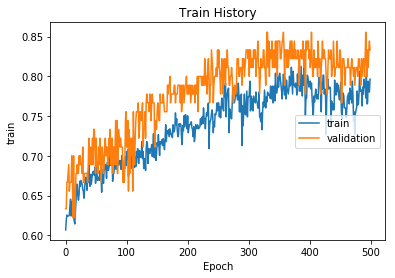

In [13]:
show_train_history(train_history,'acc','val_acc')

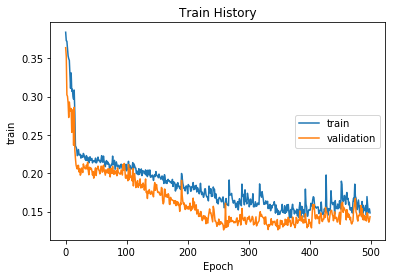

In [14]:
show_train_history(train_history, 'loss','val_loss')

In [20]:
X_test = shuffle(X_test)

In [15]:
y_pred_c = model.predict(X_test)

In [16]:
y_pred_c = np.where(y_pred_c>0.5,1,0)

In [17]:
pred = np.zeros(418)
for x in range(0,418):
    pred[x] = y_pred_c[x,0]
pred=pred.astype(int)

In [18]:
pred

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [22]:
y_pred

array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,

In [19]:
submission2=pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':pred})
submission2.to_csv('submission.csv', index=False)